# Common-nearest-neighbour clustering on MD data sets of a small peptide (PDB ID 6a5j)

In [2]:
import pathlib
import warnings

from cnnclustering import cluster, plot
from cnnclustering import _types
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj
import nglview
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
import os

In [3]:
mpl.rcParams["figure.dpi"] = 150

## Simulation data

Simulation data:

  - 5 replica à 75.000 frames (750 ns, $dt = 10$ ps)
  - 300 K
    

### (a) Load all the trajectories

In [6]:
cwd = os.getcwd()
ref_pdb = os.path.join(cwd, 'files/6a5j_protein/reference.pdb')

datadir = pathlib.Path("/home/puneek95/nobackup")
trajectory_files = [datadir / f"replica_{i}.dcd" for i in range(1, 6)]     
top_file = ref_pdb

In [7]:
trajectories = mdtraj.load([str(p) for p in trajectory_files], top=str(top_file))
trajectories

<mdtraj.Trajectory with 375000 frames, 260 atoms, 13 residues, and unitcells at 0x7f4562f14cc0>

### (b) Fit the 'trajectories' to frame 0 and center coordinates

In [8]:
fit_traj = os.path.join(cwd, 'files/6a5j_protein/fitted_trajectory.dcd')

fitted_trajectories = trajectories.superpose(trajectories, frame=0, 
                                           atom_indices=trajectories.topology.select("protein and backbone")).center_coordinates()
fitted_trajectories.save_dcd(fit_traj)

In [9]:
fitted_trajectories

<mdtraj.Trajectory with 375000 frames, 260 atoms, 13 residues, and unitcells at 0x7f4562f14cc0>

### (c) Visualize 'fitted_trajectories' in VMD

In [10]:
view = nglview.show_mdtraj(fitted_trajectories)
view.representations = [
    {
        "type": "cartoon",
        "params": {
            "sele": "protein",
            "color": "sstruc"
        }
    },
    {
        "type": "spacefill",
        "params": {
            "sele": "ion"
        }
    },
    {
        "type": "licorice",
        "params": {
            "sele": "1"
        }
    },
]
view

NGLWidget(max_frame=374999)

## RMSD 

In [13]:
backbone_atoms = trajectories.topology.select("backbone")      # Consider only the backbone atoms
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rmsd = mdtraj.rmsd(trajectories, trajectories, frame=0, atom_indices=backbone_atoms)     

In [14]:
rmsd_path = os.path.join(cwd, 'files/6a5j_protein/rmsd_backbone.npy')
np.save(rmsd_path, rmsd)     # Save the trajectory

In [15]:
rmsd = np.load(rmsd_path)

In [16]:
rmsd.shape

(375000,)

Text(0, 0.5, 'probability density')

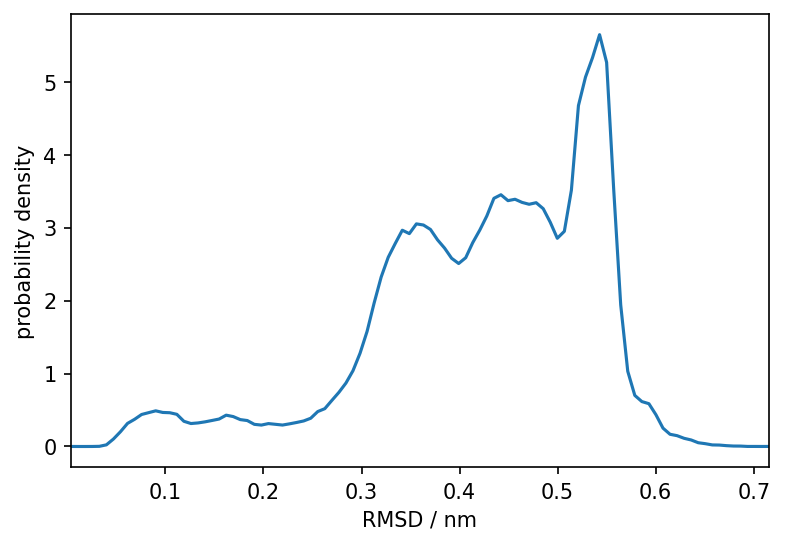

In [10]:
h, e = np.histogram(rmsd, bins=100, density=True)
e = (e[:-1] + e[1:]) / 2
fig, ax = plt.subplots()
ax.plot(e, h)
ax.set_xlim(e[0], e[-1])
ax.set_xlabel("RMSD / nm")
ax.set_ylabel("probability density")

In [11]:
# Striding for faster clustering
rmsd_reduced = rmsd[::10]     # Select only every 10th point in the trajectory

In [12]:
clustering = cluster.prepare_clustering(np.atleast_2d(rmsd_reduced).T)

In [13]:
clustering.input_data.shape

(37500, 1)

In [14]:
# Pre-compute distances for inspection
distances = pairwise_distances(clustering.input_data)
distance_clustering = cluster.prepare_clustering(distances)
distance_clustering._metric = _types.MetricExtPrecomputed()

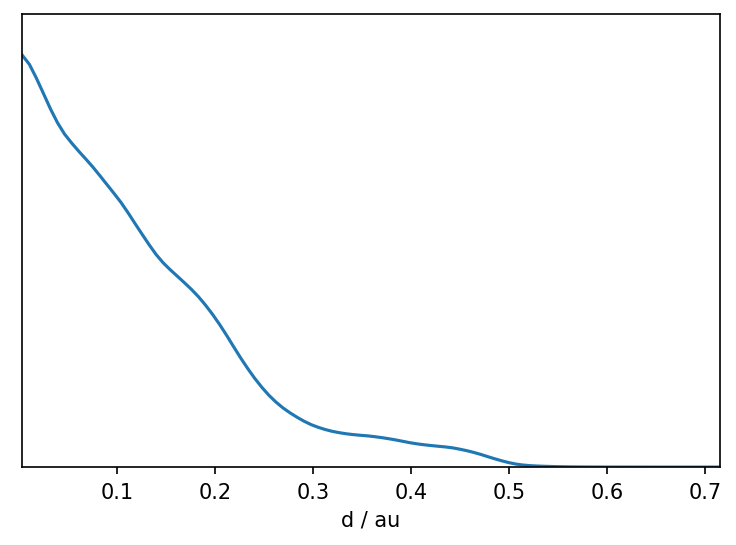

In [15]:
fig, ax = plt.subplots()
_ = plot.plot_histogram(ax, distances.flatten(), maxima=True, maxima_props={"order": 5})

Cluster parameter scan in which $c$ is kept constant and $r$ is gradually decreased over a meaning full range (start: 1 cluster, end: almost all points noise). Member cutoff to filter out very small clusters.

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.002     10        20        None      1         0.998     0.002     00:00:5.028
-----------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.002     10        20        None      1         0.998     0.002     00:00:4.978
-----------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.001     10        20        None      4         0.93

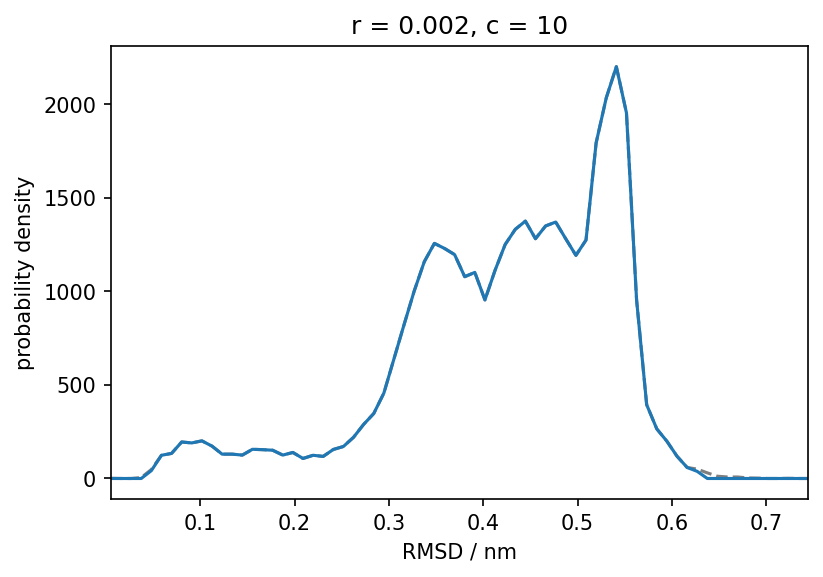

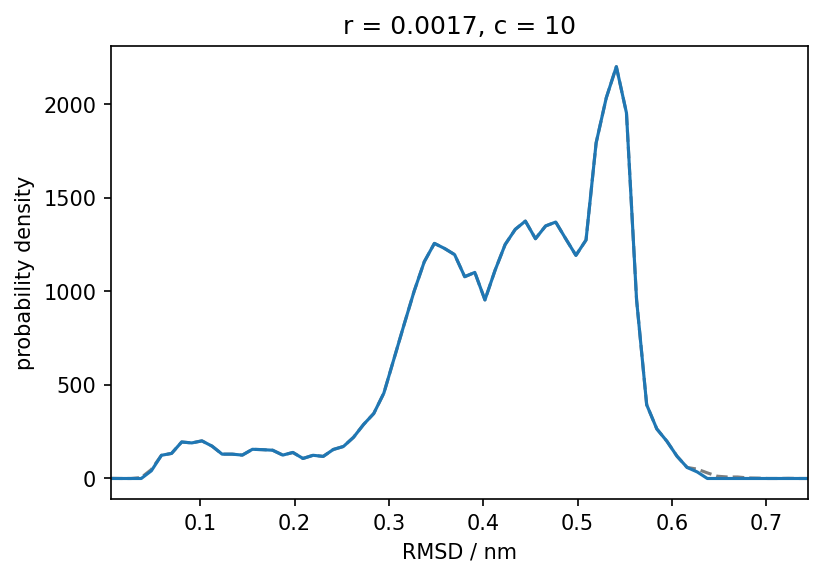

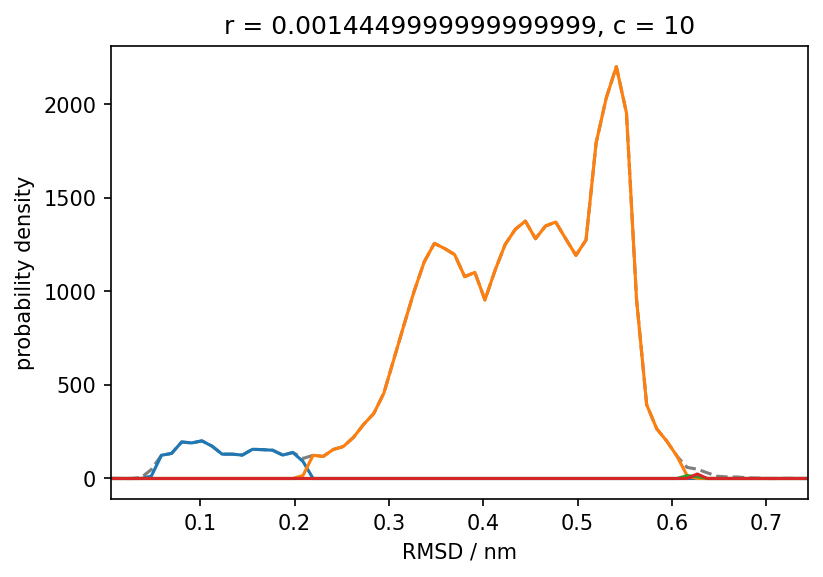

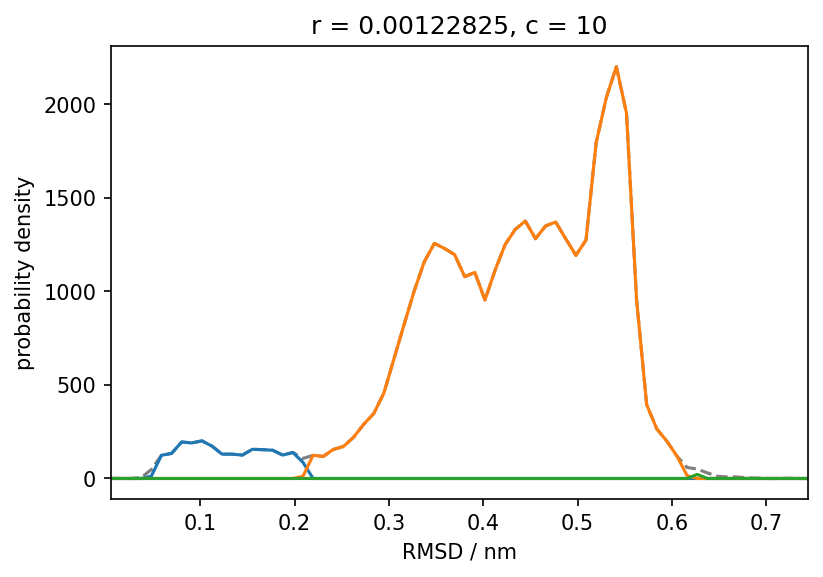

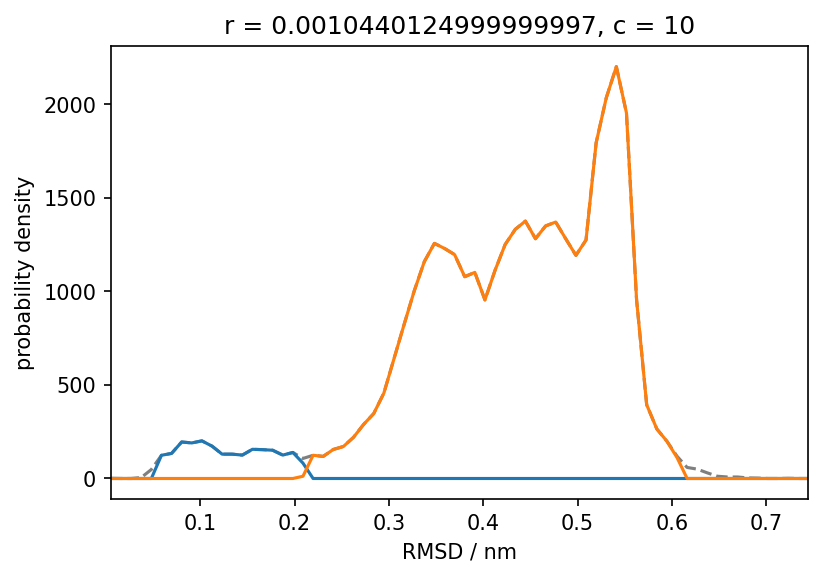

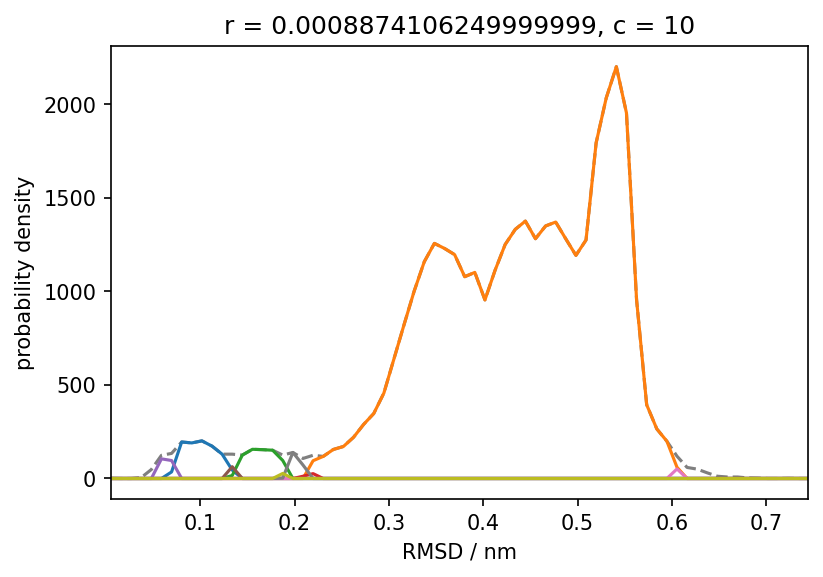

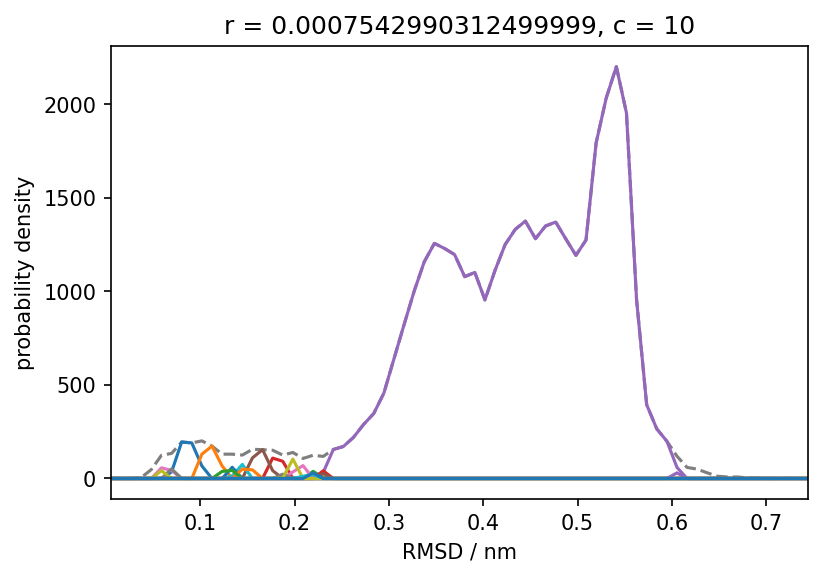

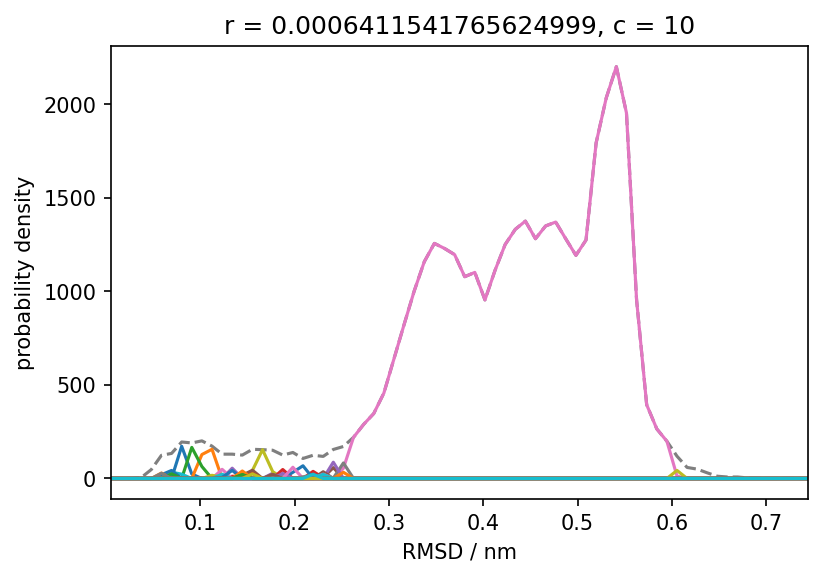

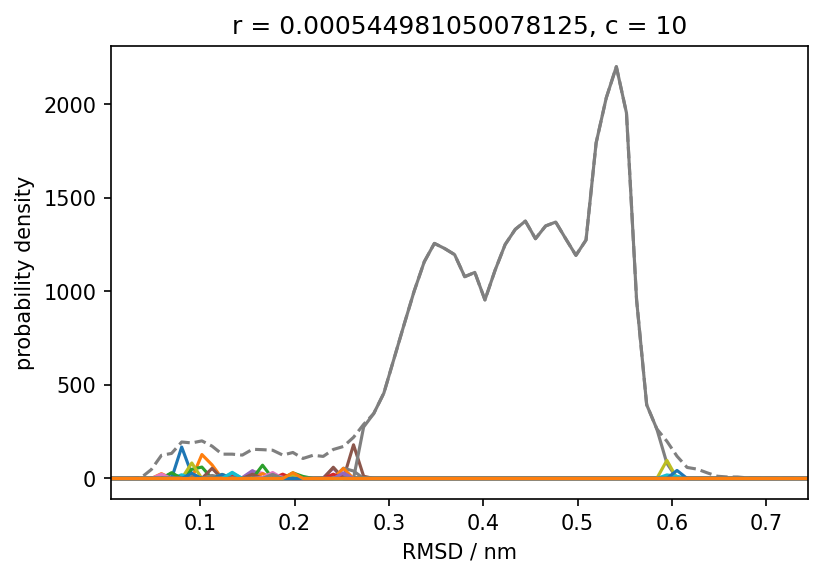

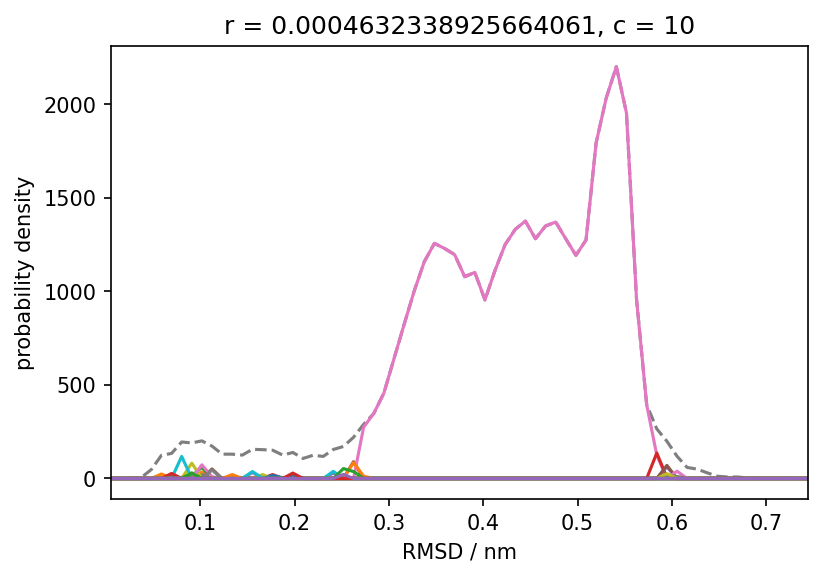

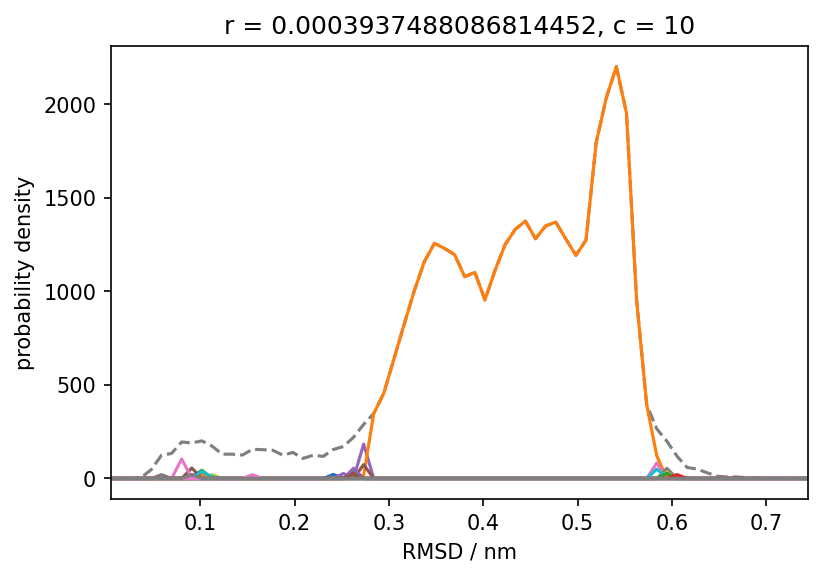

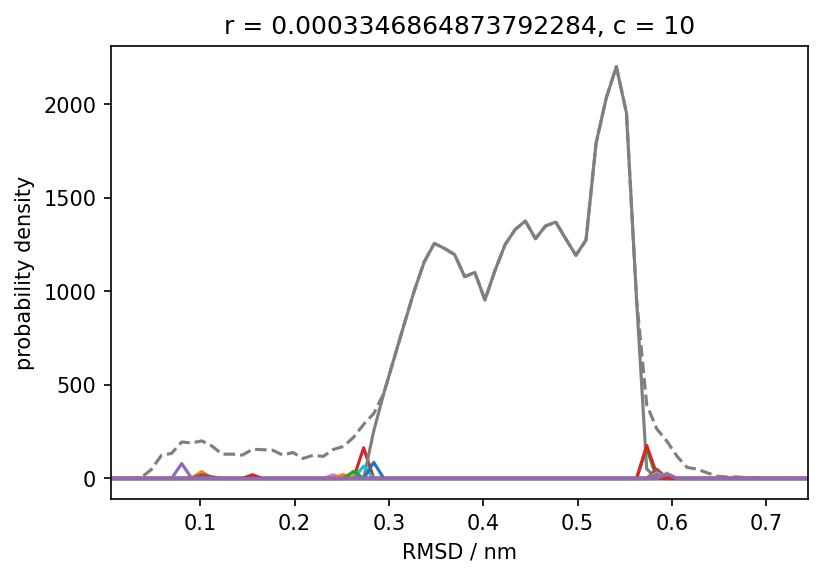

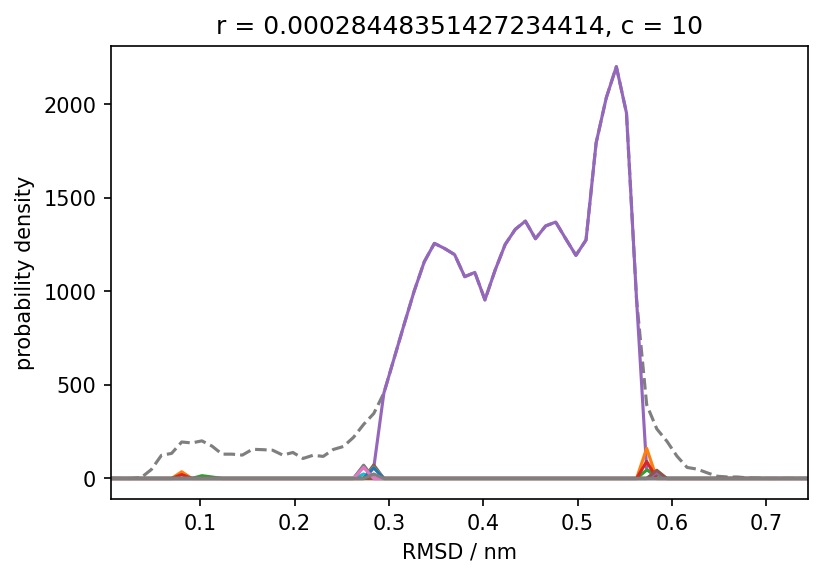

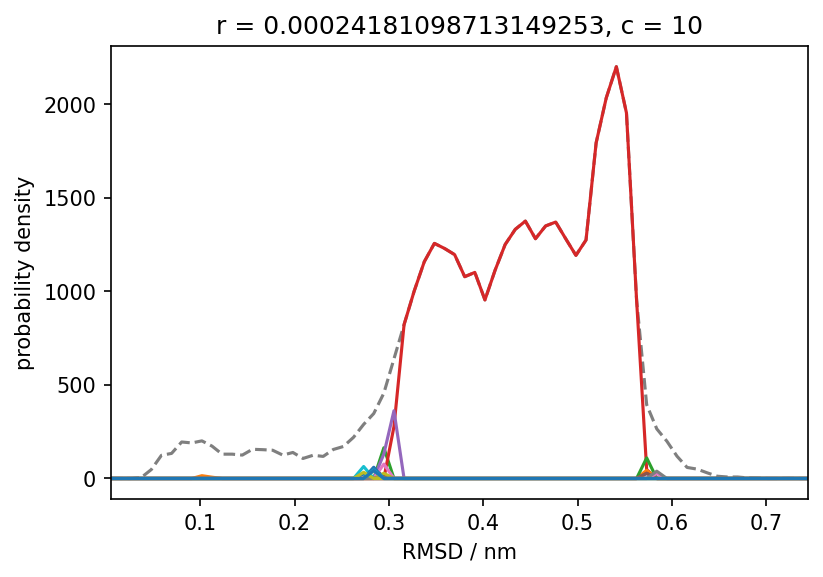

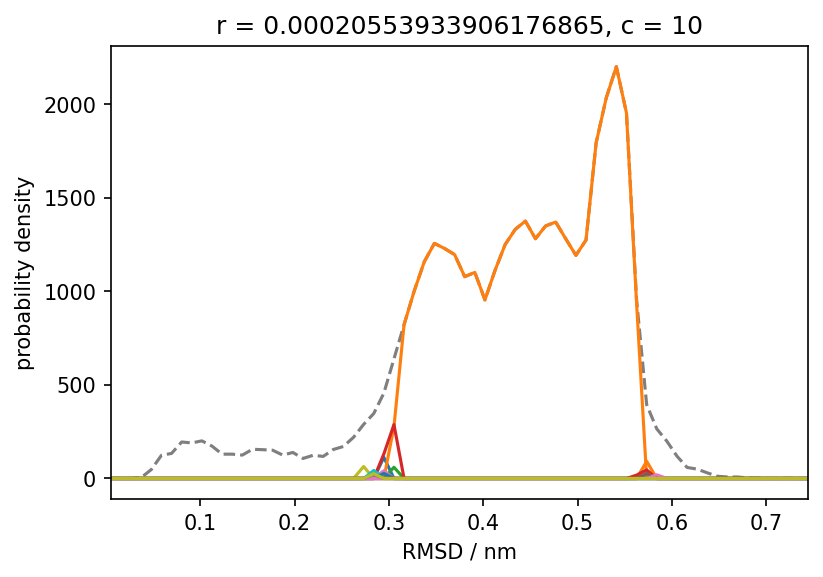

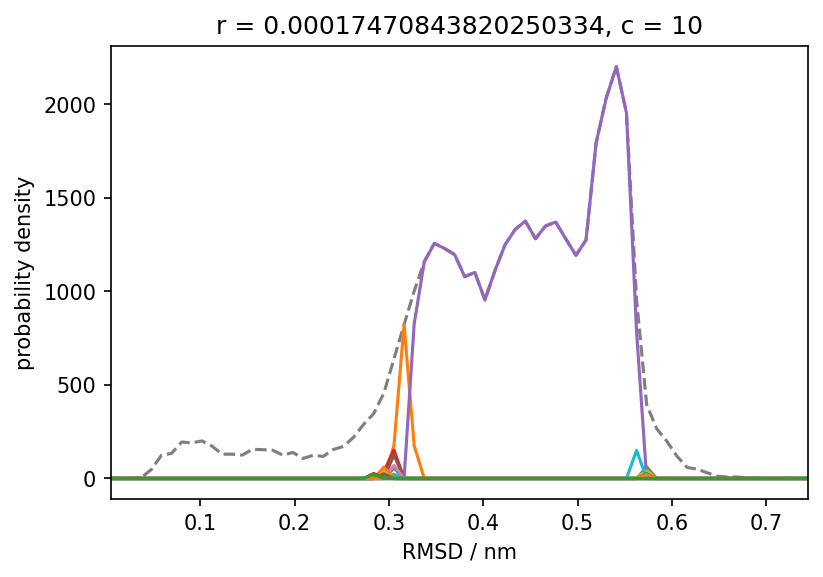

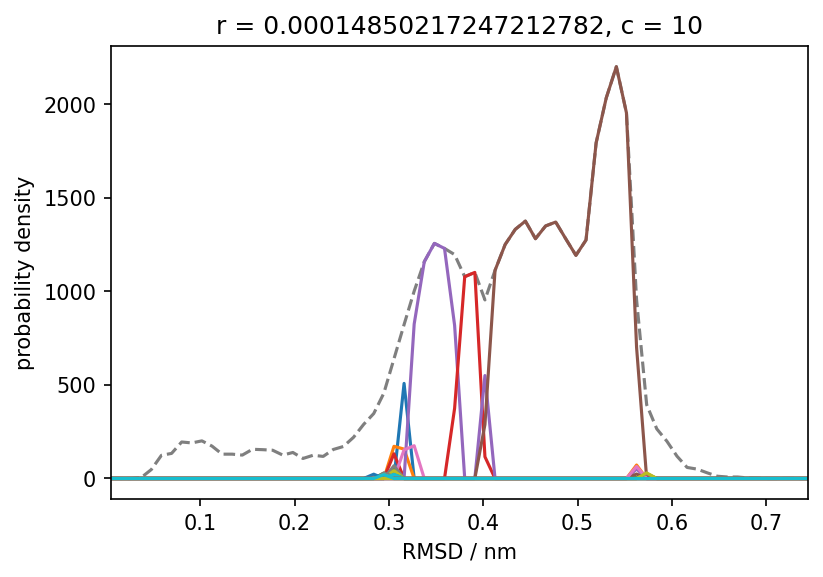

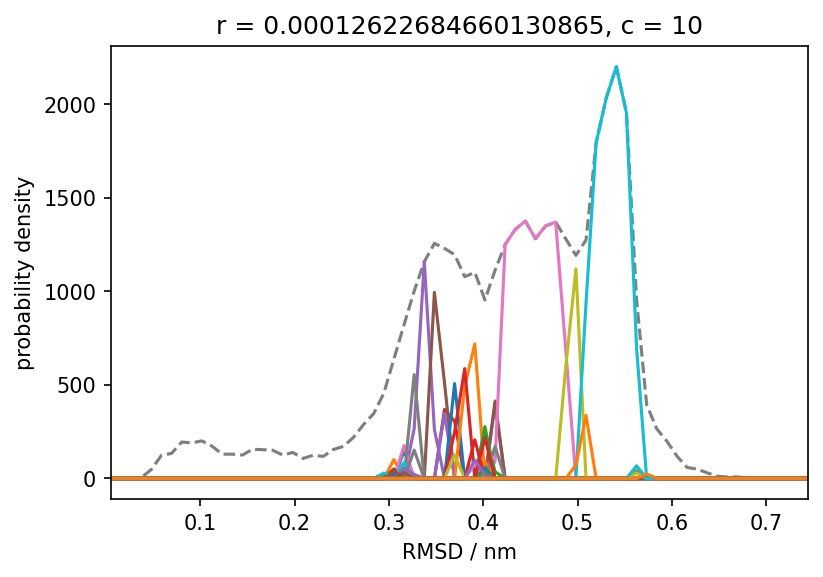

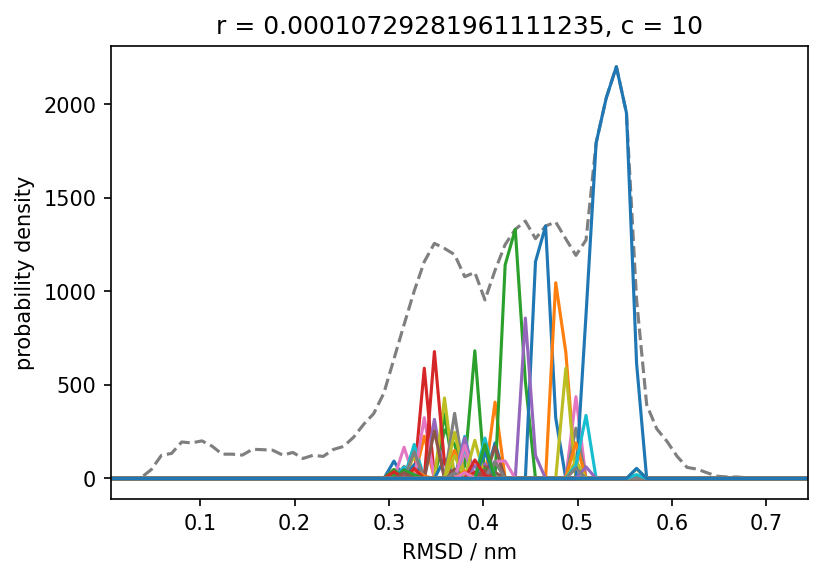

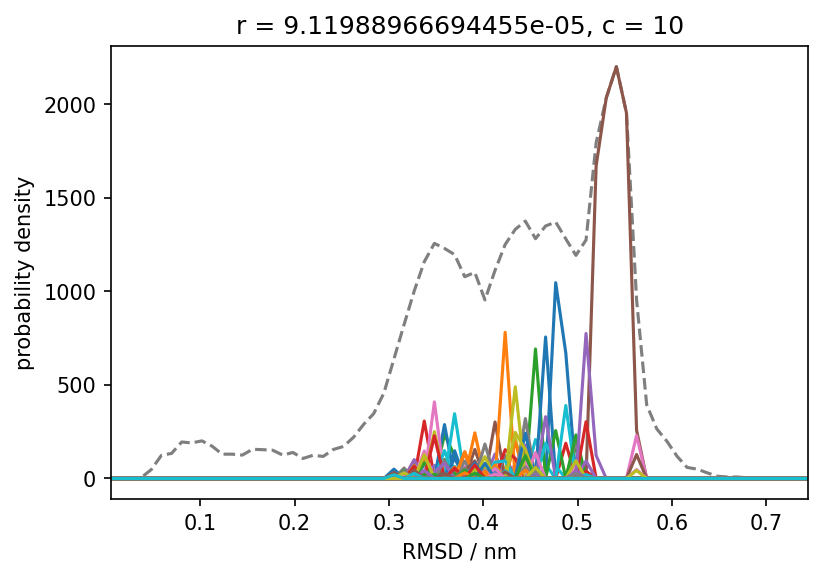

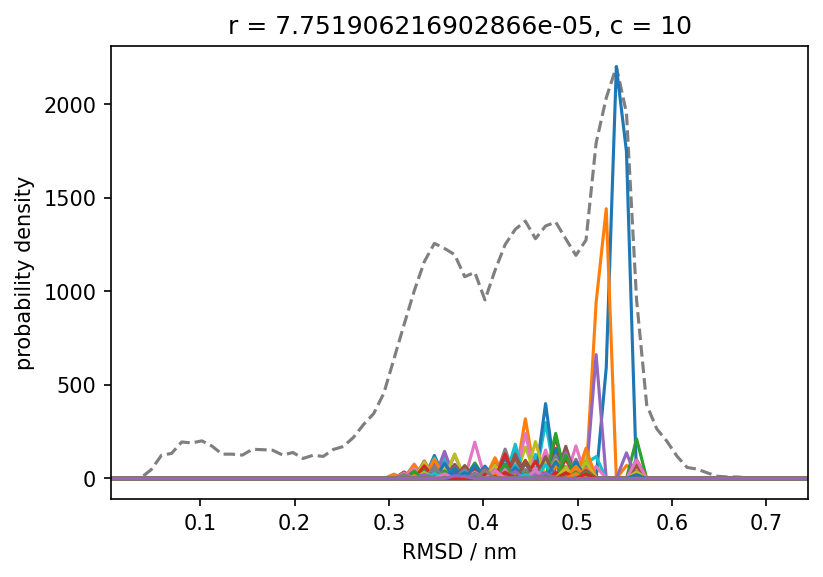

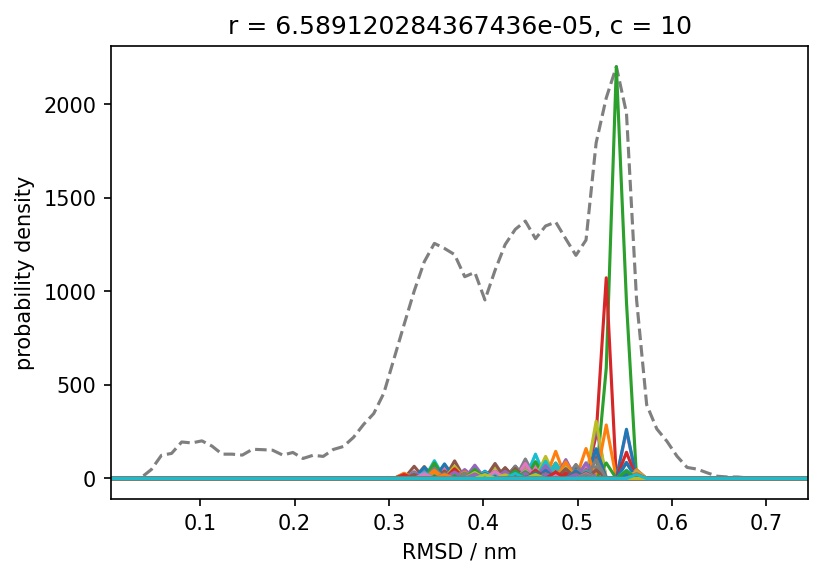

In [16]:
c = 10
for r in [0.002 * 0.85 ** i for i in range(22)]:

    distance_clustering.fit(r, c, member_cutoff=20)

    fig, ax = plt.subplots()

    h, e = np.histogram(rmsd_reduced, bins=70, density=False, range=(0, 0.75))
    e = (e[:-1] + e[1:]) / 2

    ax.plot(e, h, "k--", alpha=0.5)

    for label, indices in distance_clustering.labels.mapping.items():
        if label == 0:
            continue  

        h, e = np.histogram(rmsd_reduced[indices], bins=70, density=False, range=(0, 0.75))
        e = (e[:-1] + e[1:]) / 2

        ax.plot(e, h)
    ax.set_xlim(e[0], e[-1])
    ax.set_xlabel("RMSD / nm")
    ax.set_ylabel("probability density")
    ax.set_title(f"r = {r}, c = {c}")

Similar scan as above but for other values of $c$. Silenced, no plotting, but results are recorded.

In [17]:
for c in [0, 1, 5, 20, 40]: 
    for r in [0.002 * 0.85 ** i for i in range(22)]:

        distance_clustering.fit(r, c, member_cutoff=20, v=False)

### Scan summary

In [18]:
distance_clustering.summary.to_DataFrame()

n_points  radius_cutoff  cnn_cutoff  member_cutoff  max_clusters  \
0       37500       0.002000          10             20          <NA>   
1       37500       0.001700          10             20          <NA>   
2       37500       0.001445          10             20          <NA>   
3       37500       0.001228          10             20          <NA>   
4       37500       0.001044          10             20          <NA>   
..        ...            ...         ...            ...           ...   
127     37500       0.000126          40             20          <NA>   
128     37500       0.000107          40             20          <NA>   
129     37500       0.000091          40             20          <NA>   
130     37500       0.000078          40             20          <NA>   
131     37500       0.000066          40             20          <NA>   

     n_clusters  ratio_largest  ratio_noise  execution_time  
0             1       0.997653     0.002347        5.028170  
1             1       0.997547     0.002453        4.978279  
2             4       0.935200     0.004000        4.933352  
3             3       0.935093     0.004960        4.883025  
4             2       0.934507     0.006587        4.871422  
..          ...            ...          ...             ...  
127          53       0.010640     0.847893        7.214598  
128          53       0.003227     0.927280        5.194571  
129          15       0.001627     0.984160        3.200143  
130           3       0.000827     0.998027        2.468869  
131           0       0.000000     1.000000        2.334754  

[132 rows x 9 columns]

(6.589120284367436e-05, 0.00075)

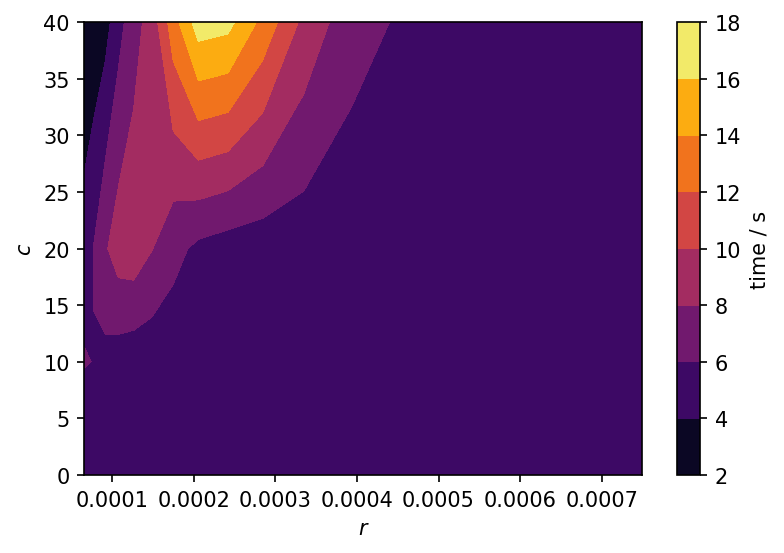

In [19]:
# Computing time
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="execution_time")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax)
colorbar.set_label("time / s")
ax.set_xlim(None, 0.00075)

(6.589120284367436e-05, 0.00075)

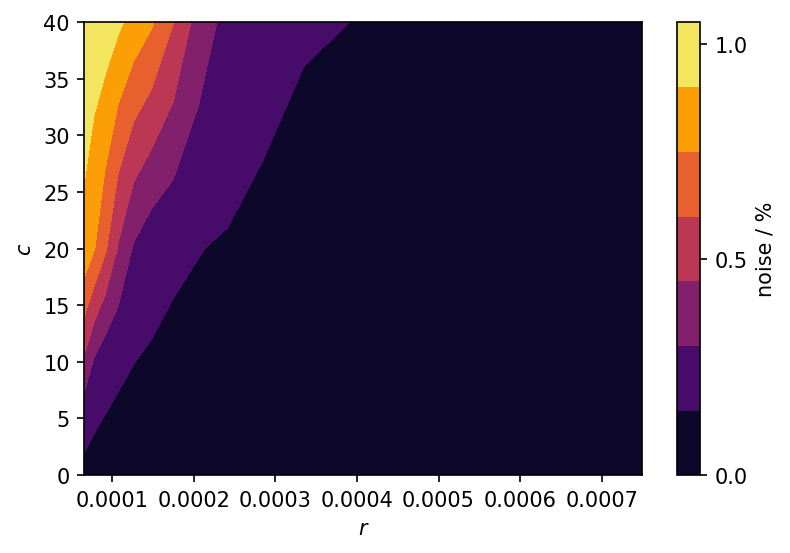

In [20]:
# Noise level
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="ratio_noise")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("noise / %")
ax.set_xlim(None, 0.00075)

(6.589120284367436e-05, 0.00075)

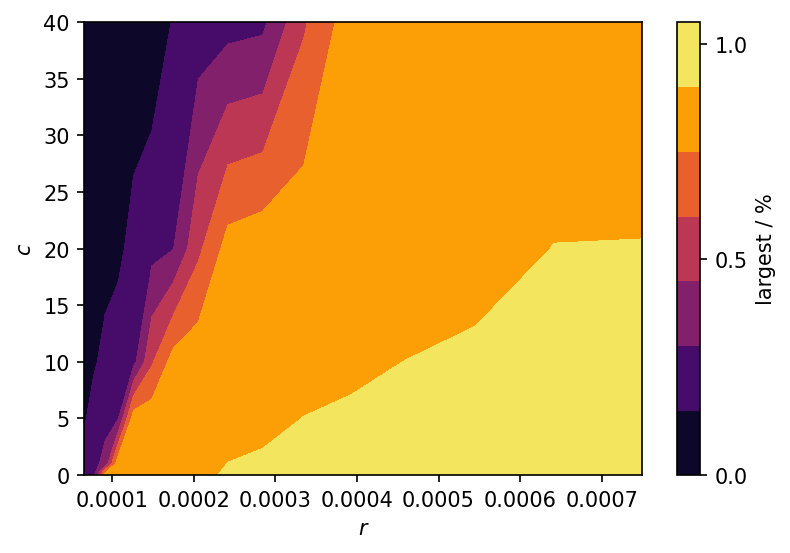

In [21]:
# Largest cluster
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="ratio_largest")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("largest / %")
ax.set_xlim(None, 0.00075)

(6.589120284367436e-05, 0.00075)

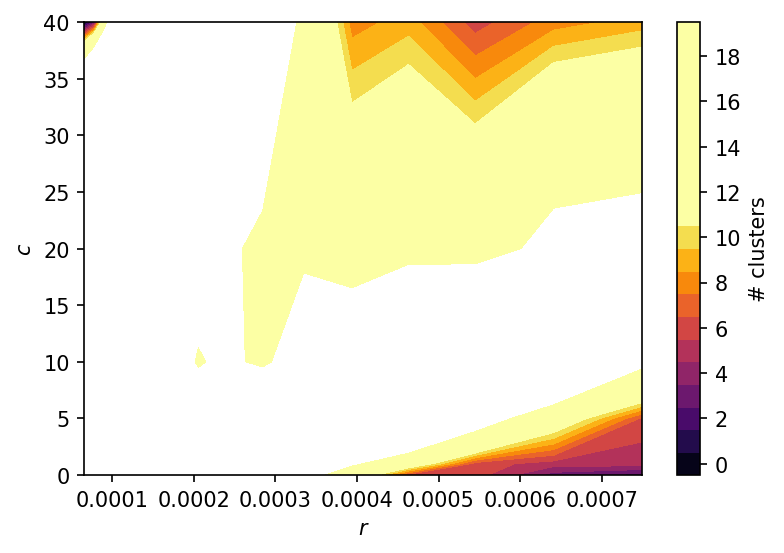

In [23]:
# Largest cluster
show_n = 20

fig, ax = plt.subplots()
contour = distance_clustering.summarize(
    ax=ax,
    quantity="n_clusters",
    contour_props={"levels": np.arange(-0.5, show_n, 1),
               "vmax": 11}
)[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=range(0, show_n + 1, 2))
colorbar.set_label("# clusters")
ax.set_xlim(None, 0.00075)

# PCA

In [17]:
pca = PCA(n_components=2)    
fitted_trajectories.xyz.shape

(375000, 260, 3)

In [18]:
pca_input = fitted_trajectories.xyz.reshape(fitted_trajectories.n_frames, fitted_trajectories.n_atoms * 3)
pca_input.shape

(375000, 780)

In [19]:
trajectory_pca = pca.fit_transform(pca_input)
trajectory_pca.shape

(375000, 2)

In [20]:
pca_path = os.path.join(cwd, 'files/6a5j_protein/pca.npy')
np.save(pca_path, trajectory_pca)     # Save the trajectory

In [21]:
pca_traj = np.load(pca_path)

In [22]:
pca_traj.shape

(375000, 2)

In [93]:
pca_clustering = cluster.prepare_clustering(trajectory_pca)

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f72a16ec4e0>)

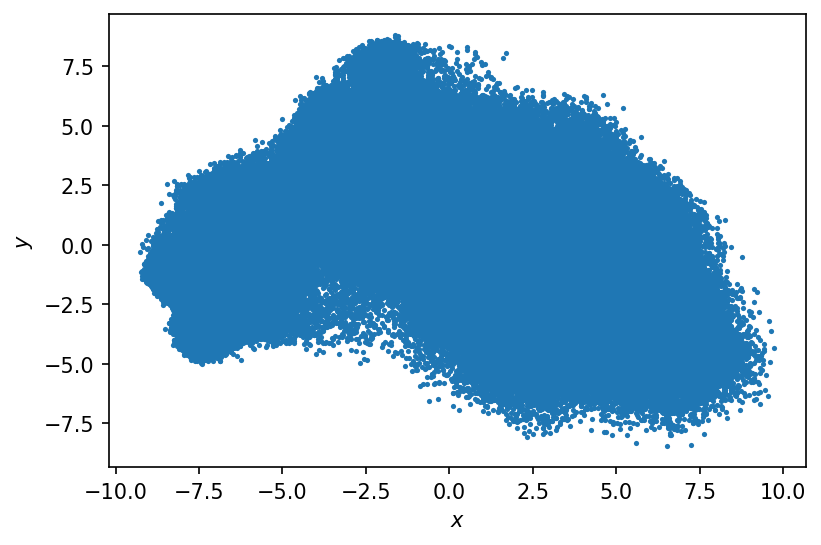

In [94]:
pca_clustering.evaluate()

(<Figure size 900x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f72a0fadf28>)

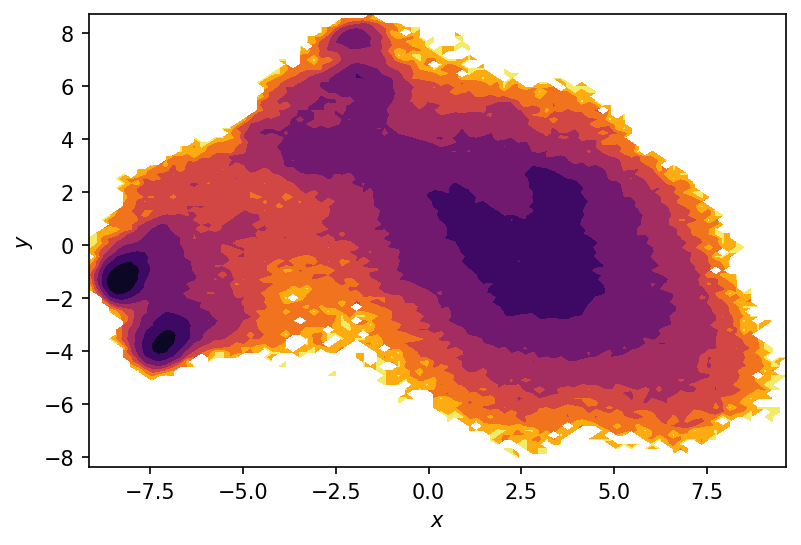

In [95]:
pca_clustering.evaluate(plot_style="contourf")

In [96]:
pca_reduced = pca_traj[::10]     # Consider every 10th point 
pca_reduced.shape

(37500, 2)

In [97]:
pca_clus = cluster.prepare_clustering(pca_reduced)

In [98]:
# Pre-compute distances for inspection
distances = pairwise_distances(pca_clus.input_data)
distance_clustering = cluster.prepare_clustering(distances)
distance_clustering._metric = _types.MetricExtPrecomputed()

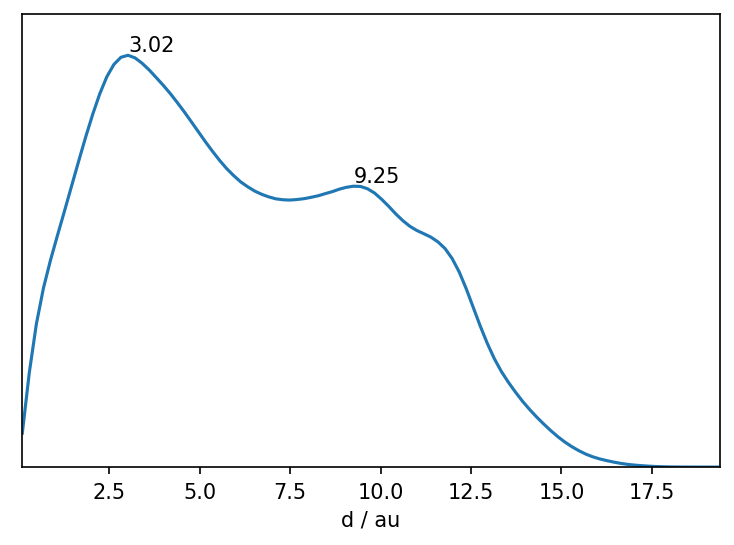

In [99]:
fig, ax = plt.subplots()
_ = plot.plot_histogram(ax, distances.flatten(), maxima=True, maxima_props={"order": 5})

**Goal**: start: 1 cluster, end: almost all points noise. Member cutoff to filter out very small clusters.

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     1.100     10        20        None      1         1.000     0.000     00:00:7.029
-----------------------------------------------------------------------------------------------



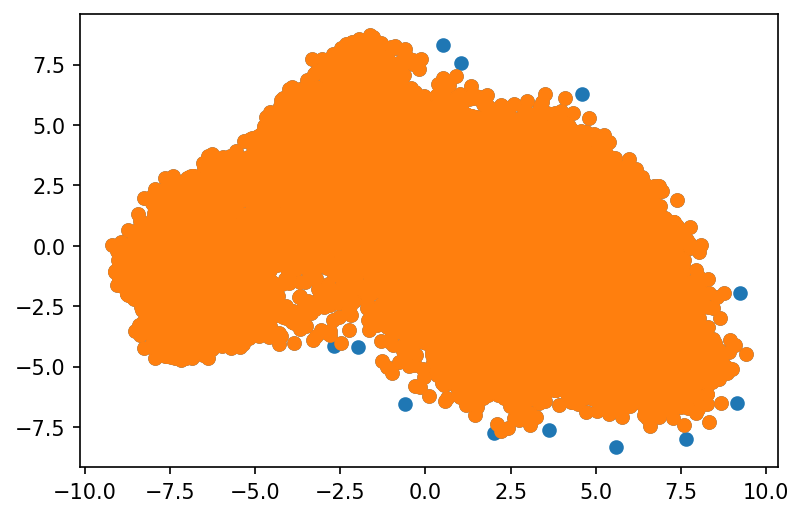

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     1.000     10        20        None      1         1.000     0.000     00:00:6.845
-----------------------------------------------------------------------------------------------



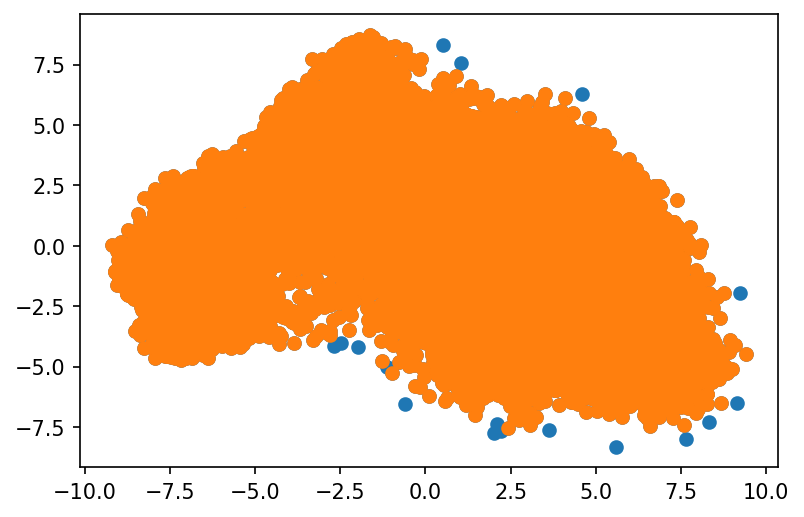

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.900     10        20        None      1         0.999     0.001     00:00:6.648
-----------------------------------------------------------------------------------------------



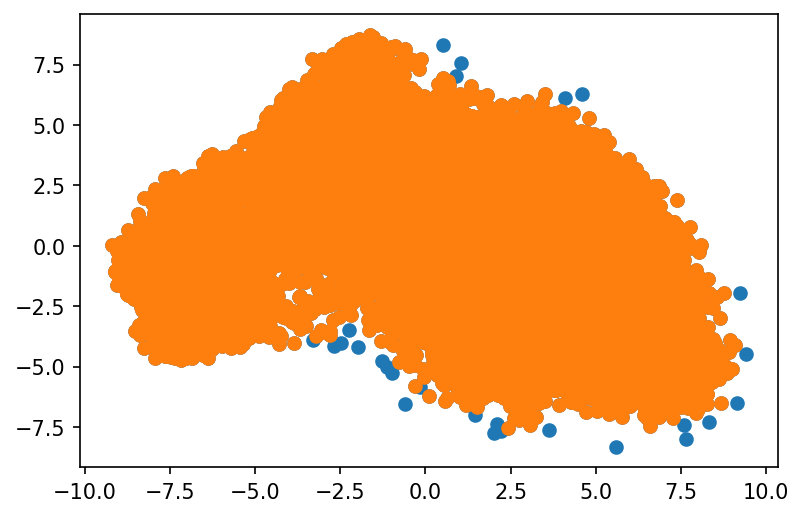

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.800     10        20        None      1         0.999     0.001     00:00:6.401
-----------------------------------------------------------------------------------------------



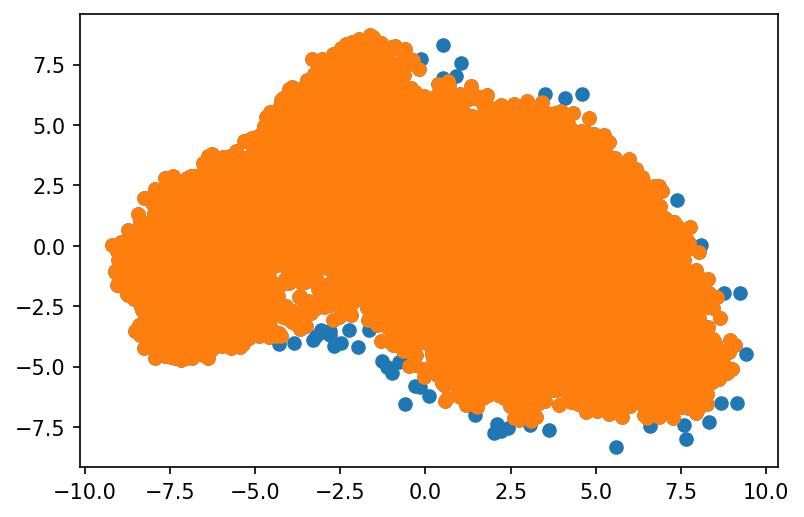

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.700     10        20        None      1         0.998     0.002     00:00:6.222
-----------------------------------------------------------------------------------------------



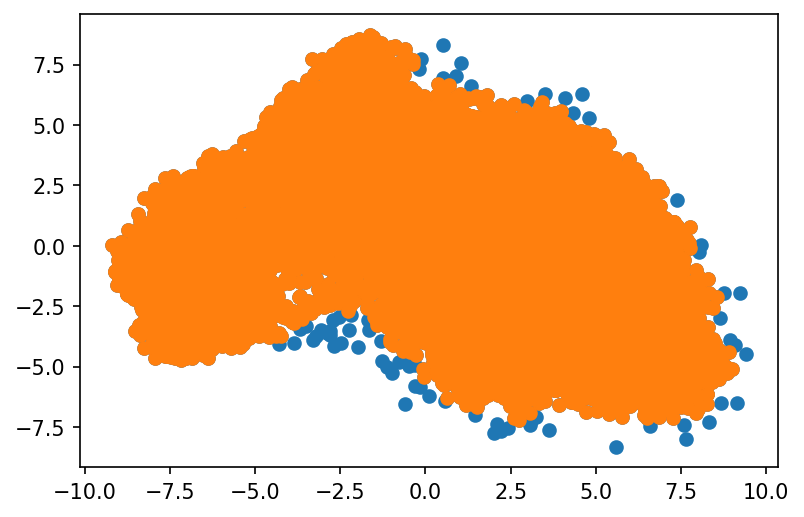

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.600     10        20        None      1         0.996     0.004     00:00:6.069
-----------------------------------------------------------------------------------------------



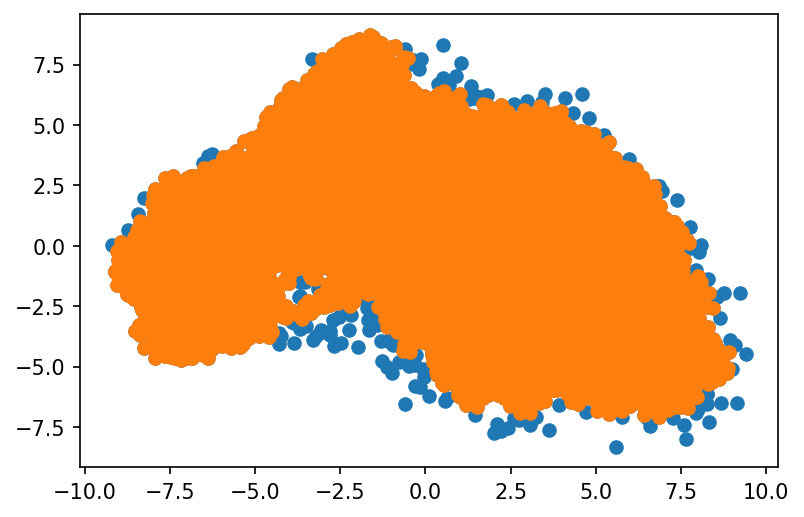

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.500     10        20        None      1         0.993     0.007     00:00:5.956
-----------------------------------------------------------------------------------------------



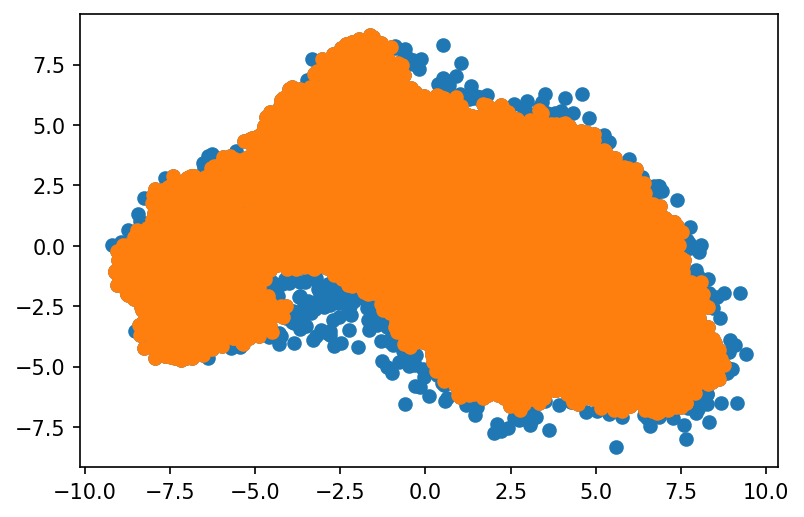

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.400     10        20        None      1         0.987     0.013     00:00:5.919
-----------------------------------------------------------------------------------------------



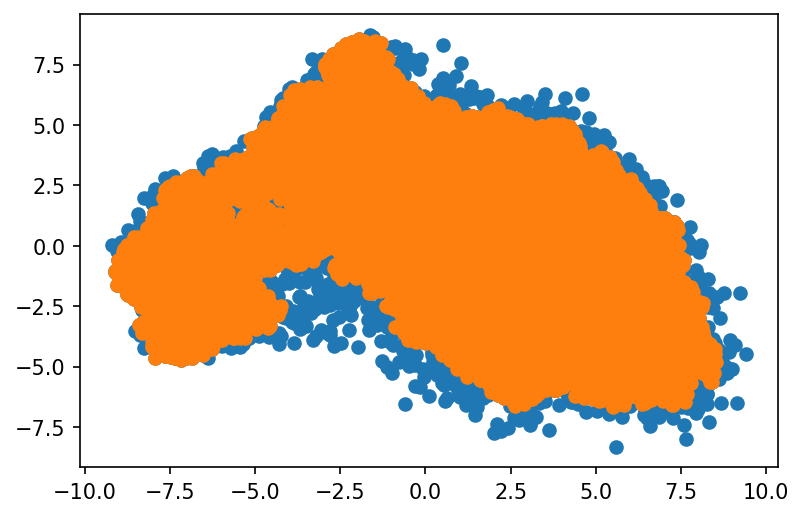

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.300     10        20        None      7         0.760     0.035     00:00:5.997
-----------------------------------------------------------------------------------------------



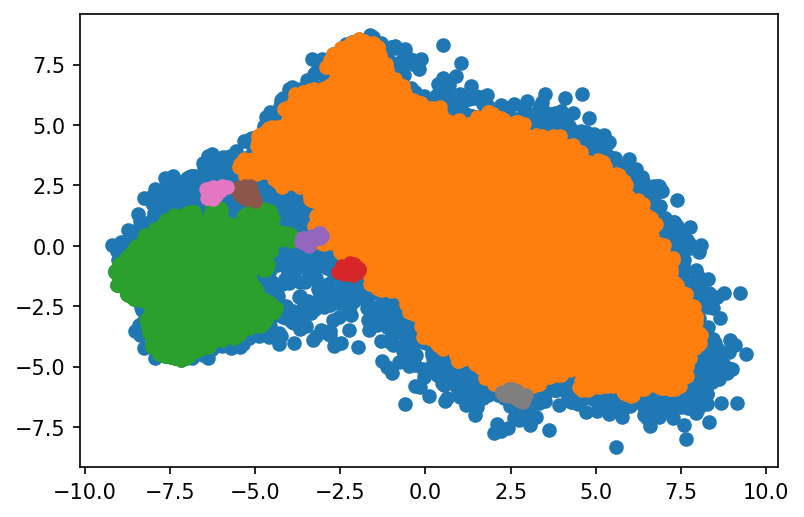

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.200     10        20        None      9         0.692     0.112     00:00:6.234
-----------------------------------------------------------------------------------------------



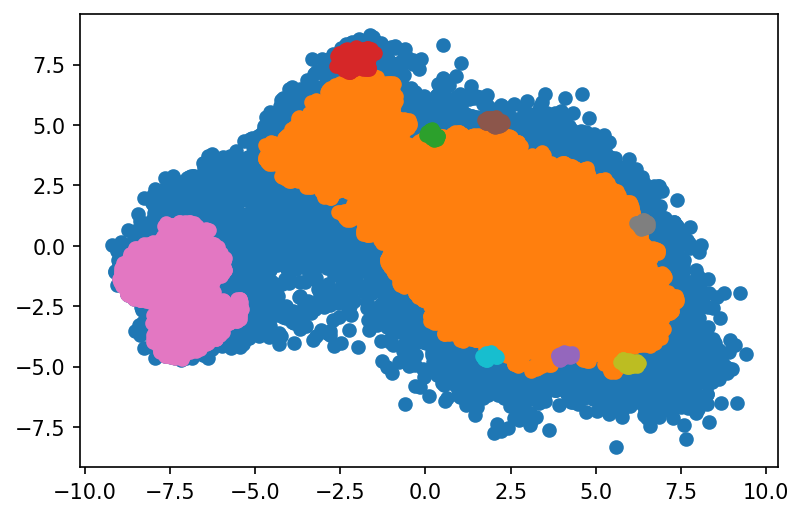

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.100     10        20        None      56        0.259     0.555     00:00:7.036
-----------------------------------------------------------------------------------------------



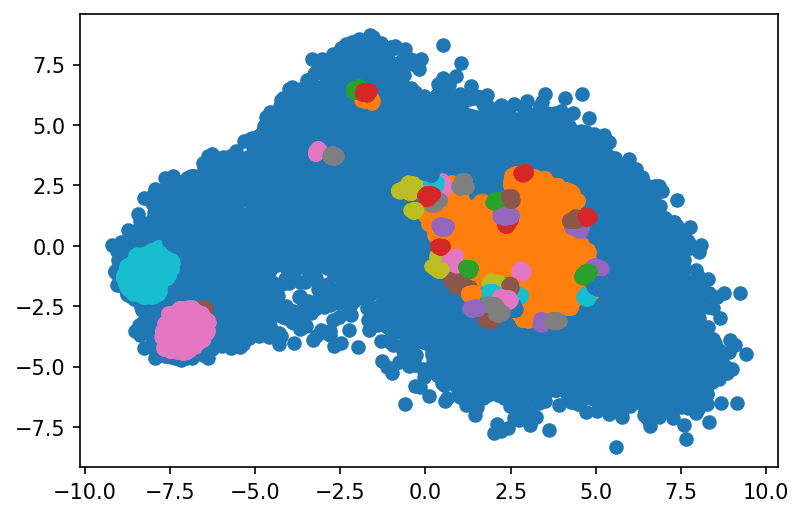

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.090     10        20        None      69        0.088     0.666     00:00:6.549
-----------------------------------------------------------------------------------------------



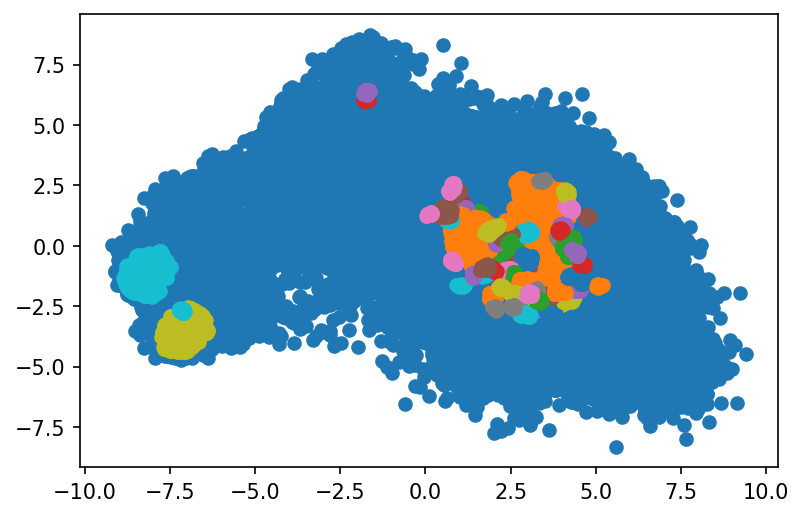

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.080     10        20        None      62        0.072     0.787     00:00:5.674
-----------------------------------------------------------------------------------------------



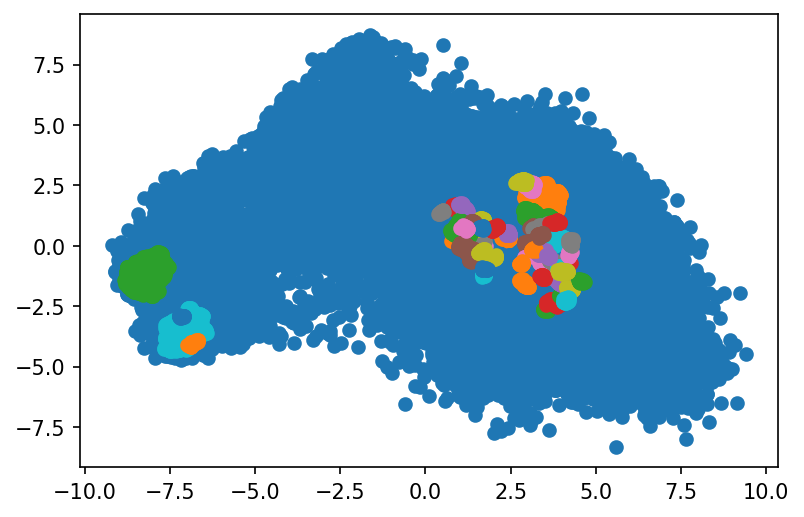

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.070     10        20        None      26        0.065     0.874     00:00:4.538
-----------------------------------------------------------------------------------------------



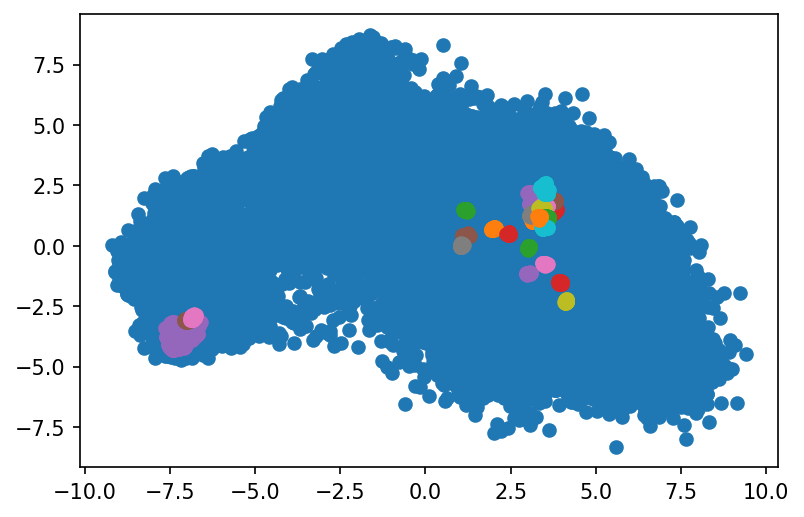

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.060     10        20        None      14        0.055     0.915     00:00:3.741
-----------------------------------------------------------------------------------------------



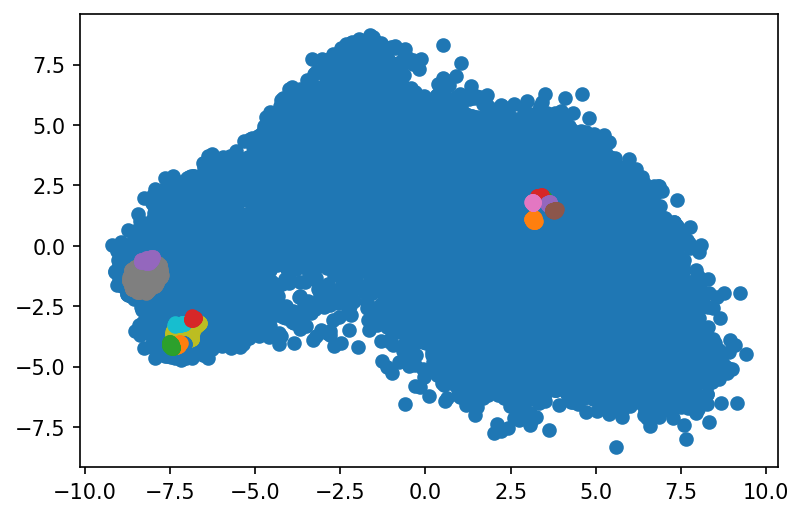

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.050     10        20        None      16        0.040     0.946     00:00:3.359
-----------------------------------------------------------------------------------------------



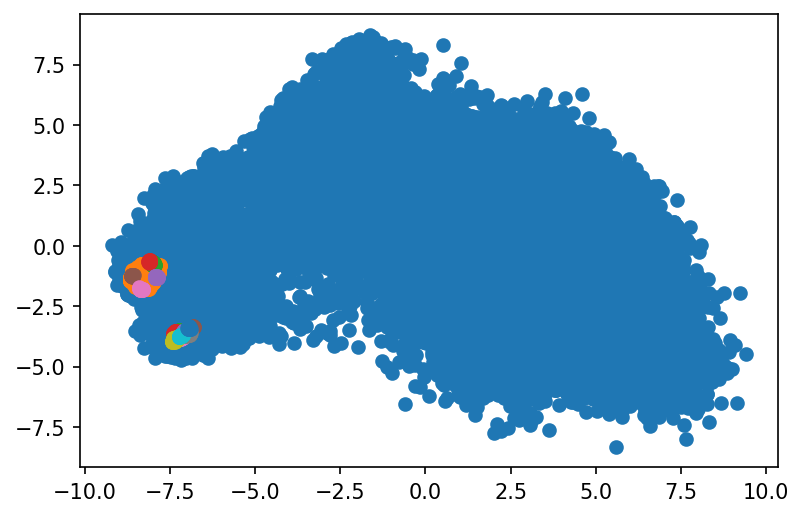

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.040     10        20        None      10        0.009     0.980     00:00:3.101
-----------------------------------------------------------------------------------------------



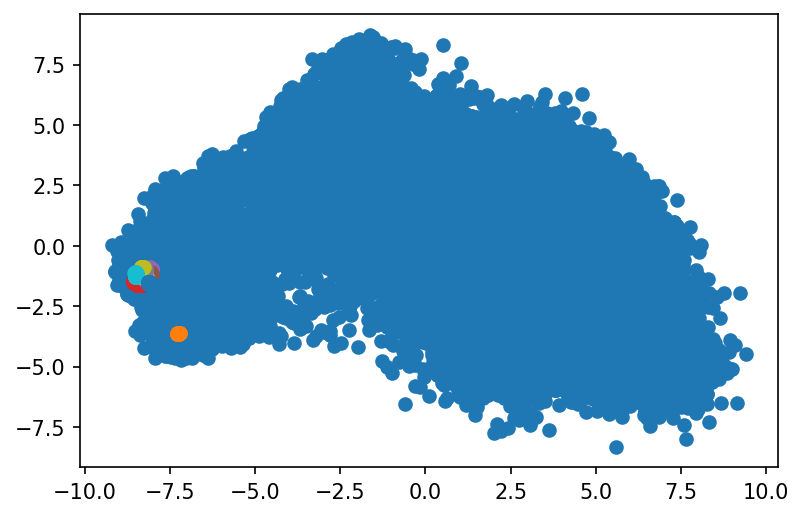

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.030     10        20        None      0         0.000     1.000     00:00:2.777
-----------------------------------------------------------------------------------------------



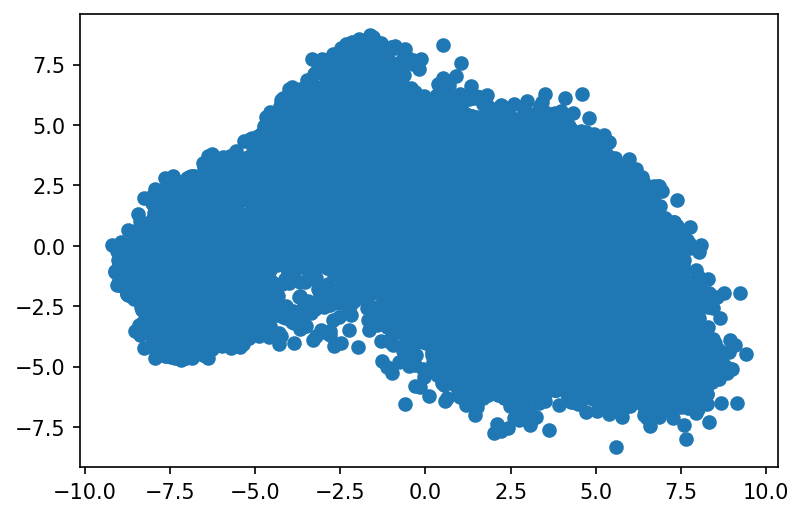

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.020     10        20        None      0         0.000     1.000     00:00:2.716
-----------------------------------------------------------------------------------------------



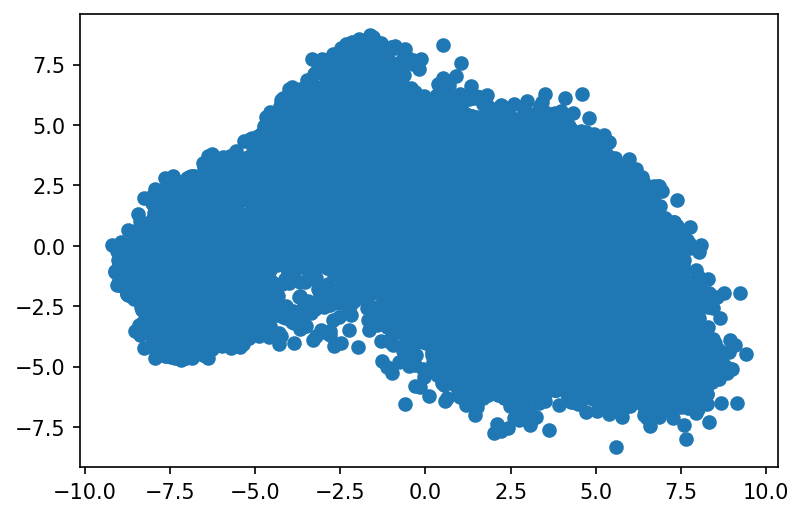

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
37500     0.010     10        20        None      0         0.000     1.000     00:00:2.729
-----------------------------------------------------------------------------------------------



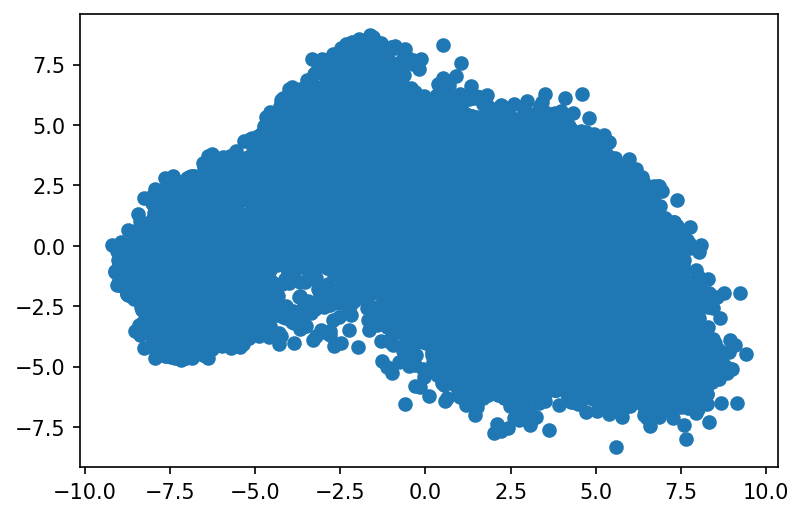

In [106]:
c = 10

for r in [1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]:
    distance_clustering.fit(r, c, member_cutoff=20)
    
    plt.figure()
    plt.scatter(pca_reduced[:,0], pca_reduced[:,1])
    
    for label, indices in distance_clustering.labels.mapping.items():
        if label == 0:
            continue
        
        pca_clusters = pca_reduced[indices]
        plt.scatter(pca_clusters[:,0], pca_clusters[:,1])
        
    plt.show()

In [43]:
for c in [0, 1, 5, 10, 20, 40]:
    for r in [1.1, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]:
        distance_clustering.fit(r, c, member_cutoff=20, v=False)

In [65]:
distance_clustering.summary.to_DataFrame()

n_points  radius_cutoff  cnn_cutoff  member_cutoff  max_clusters  \
0       37500           3.00          10             20          <NA>   
1       37500           3.00          10             20          <NA>   
2       37500           2.90          10             20          <NA>   
3       37500           2.80          10             20          <NA>   
4       37500           2.70          10             20          <NA>   
..        ...            ...         ...            ...           ...   
167     37500           0.05          40             20          <NA>   
168     37500           0.04          40             20          <NA>   
169     37500           0.03          40             20          <NA>   
170     37500           0.02          40             20          <NA>   
171     37500           0.01          40             20          <NA>   

     n_clusters  ratio_largest  ratio_noise  execution_time  
0             1            1.0          0.0       14.202682  
1             1            1.0          0.0       14.220640  
2             1            1.0          0.0       13.486371  
3             1            1.0          0.0       13.053400  
4             1            1.0          0.0       12.767592  
..          ...            ...          ...             ...  
167           0            0.0          1.0        2.695660  
168           0            0.0          1.0        2.703399  
169           0            0.0          1.0        2.698763  
170           0            0.0          1.0        2.697217  
171           0            0.0          1.0        2.697069  

[172 rows x 9 columns]

(0.01, 1.1)

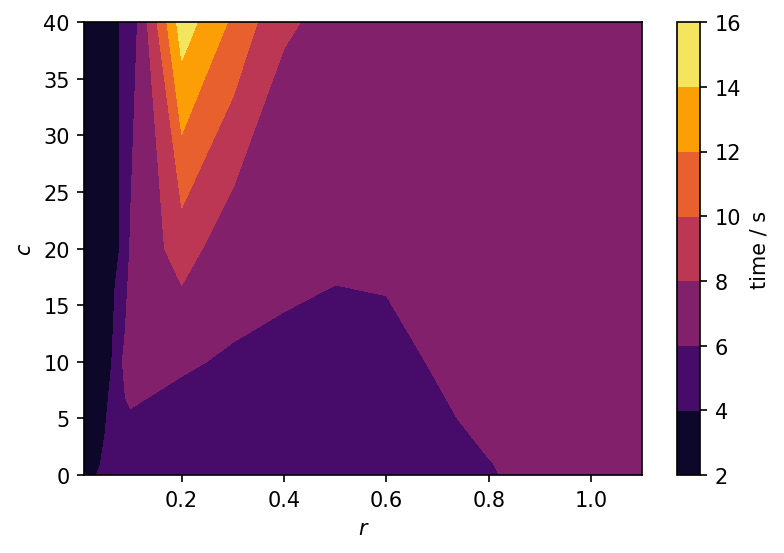

In [70]:
# Computing time
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="execution_time")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax)
colorbar.set_label("time / s")
ax.set_xlim(None, 1.1)

(0.01, 1.1)

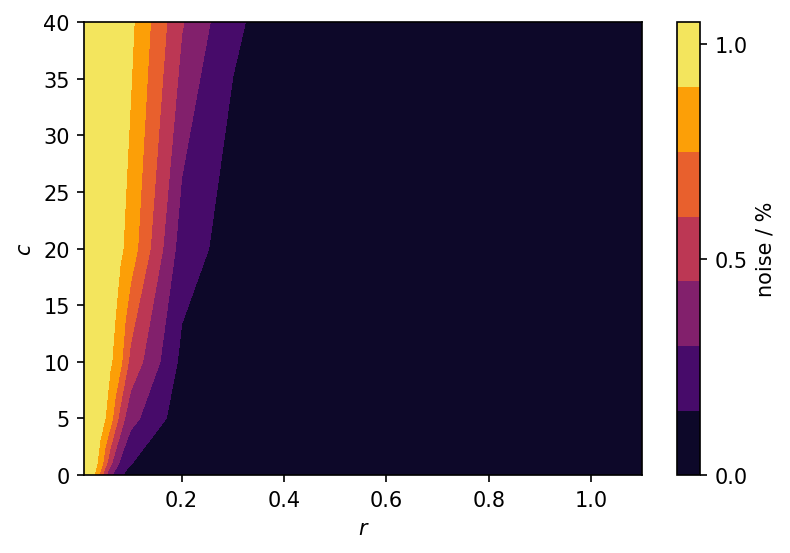

In [71]:
# Noise level
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="ratio_noise")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("noise / %")
ax.set_xlim(None, 1.1)

(0.01, 1.1)

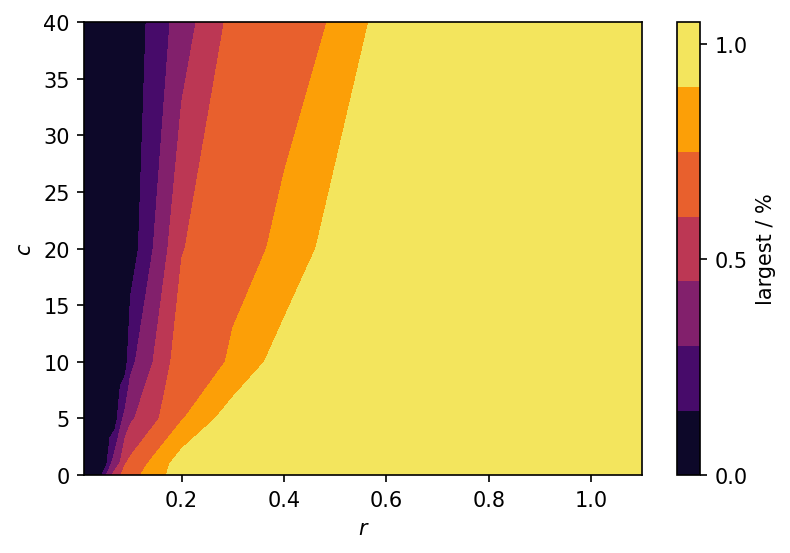

In [72]:
# Largest cluster
fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="ratio_largest")[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=(0, 0.5, 1))
colorbar.set_label("largest / %")
ax.set_xlim(None, 1.1)

(0.01, 0.2)

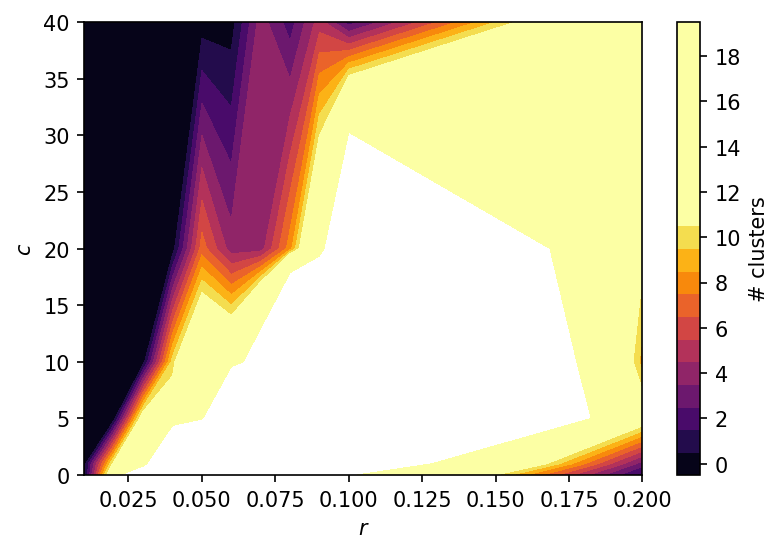

In [49]:
# Largest cluster
show_n = 20

fig, ax = plt.subplots()
contour = distance_clustering.summarize(ax=ax, quantity="n_clusters", 
                                       contour_props={"levels": np.arange(-0.5, show_n, 1),
                                       "vmax": 11})[2][0]
colorbar = fig.colorbar(mappable=contour, ax=ax, ticks=range(0, show_n + 1, 2))
colorbar.set_label("# clusters")
ax.set_xlim(None, 0.2)